In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime 
from sklearn.cluster import KMeans ,DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
import json
NOW = datetime.now()

In [2]:
with open("data/sample.json","r",encoding = "utf-8") as f: 
    data = json.load(f)

data = [{'pk':a['pk'],
         'customer_ID':str(int(a['fields']['phone'])),
         'price':int(a['fields']['price']),
         'date':datetime.strptime(a['fields']['date'][:10],"%Y-%m-%d")} 
        for a in data if a["fields"]["order_condition"] == "4"
       ]

In [3]:
for index , d in enumerate(data):
    if d["customer_ID"][0:2] == "98":
        data[index]["customer_ID"] = d["customer_ID"][2:]
    if not len(d["customer_ID"]) == 10:
        data.pop(index)

In [4]:
df = pd.DataFrame(data)
df.head()

,pk,customer_ID,price,date
0,0,9127734220,6541890,2024-02-14
1,1,9614810601,4333681,2022-01-02
2,2,9556693635,16104248,2022-12-27
3,3,9031807567,12560273,2022-04-13
4,4,9031807567,6846358,2022-05-23


# Recency Table

In [5]:
df_recency = df.groupby(['customer_ID'],as_index=False)['date'].max()
df_recency.columns = ['customer_ID','Last_Purchase_Date']
df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)

In [6]:
df_recency.head()

,customer_ID,Recency
0,9000641603,452
1,9001201270,414
2,9001314396,389
3,9001781541,287
4,9001960288,139


# FM Table

In [7]:
FM_Table = df.groupby('customer_ID').agg({'pk': lambda x:len(x),'price': lambda x:x.sum()})
FM_Table.rename(columns = {'pk' :'Frequency','price':'Monetary'},inplace= True) 

In [8]:
FM_Table.head()

,Frequency,Monetary
customer_ID,,
9000641603,1,17020876
9001201270,1,14520670
9001314396,1,9419368
9001781541,2,27260006
9001960288,2,20521137


# RFM Table

In [9]:
RFM_Table = df_recency.merge(FM_Table,left_on='customer_ID',right_on='customer_ID')

In [10]:
RFM_Table.head()

,customer_ID,Recency,Frequency,Monetary
0,9000641603,452,1,17020876
1,9001201270,414,1,14520670
2,9001314396,389,1,9419368
3,9001781541,287,2,27260006
4,9001960288,139,2,20521137


# Split into metrics and Scores


In [11]:
RFM_Table = RFM_Table.copy()

r_labels = range(4, 0, -1)
r_groups = pd.qcut(RFM_Table['Recency'], q=4, labels=r_labels)
f_labels = range(1,5)
normalized = preprocessing.normalize([RFM_Table['Frequency']])
f_groups = pd.cut(normalized[0], bins=4, labels=f_labels)
m_labels = range(1,5)
m_groups = pd.qcut(RFM_Table['Monetary'], q=4, labels=m_labels)
RFM_Table['R'] = r_groups
RFM_Table['F'] = f_groups
RFM_Table['M'] = m_groups

In [12]:
RFM_Table.head()

,customer_ID,Recency,Frequency,Monetary,R,F,M
0,9000641603,452,1,17020876,2,1,2
1,9001201270,414,1,14520670,2,1,2
2,9001314396,389,1,9419368,2,1,1
3,9001781541,287,2,27260006,2,1,3
4,9001960288,139,2,20521137,3,1,3


# KMeans

In [13]:
X = RFM_Table[['R','F','M']]
kmean= KMeans(n_clusters=3)
kmean.fit(X)
RFM_Table['KCluster'] = kmean.labels_

In [14]:
RFM_Table.head()

,customer_ID,Recency,Frequency,Monetary,R,F,M,KCluster
0,9000641603,452,1,17020876,2,1,2,1
1,9001201270,414,1,14520670,2,1,2,1
2,9001314396,389,1,9419368,2,1,1,1
3,9001781541,287,2,27260006,2,1,3,1
4,9001960288,139,2,20521137,3,1,3,0


<Axes: xlabel='KCluster', ylabel='Recency'>

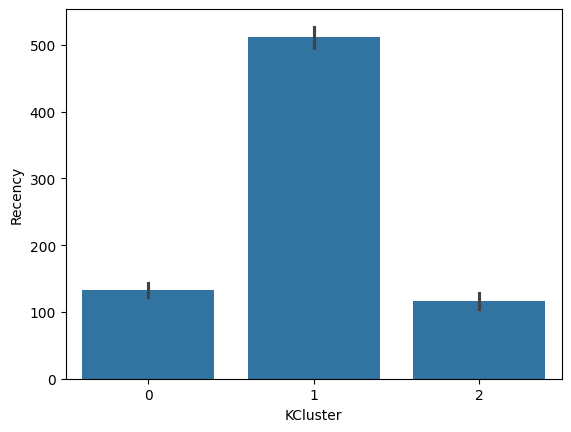

In [15]:
sns.barplot(data=RFM_Table, x='KCluster', y='Recency')

<Axes: xlabel='KCluster', ylabel='Monetary'>

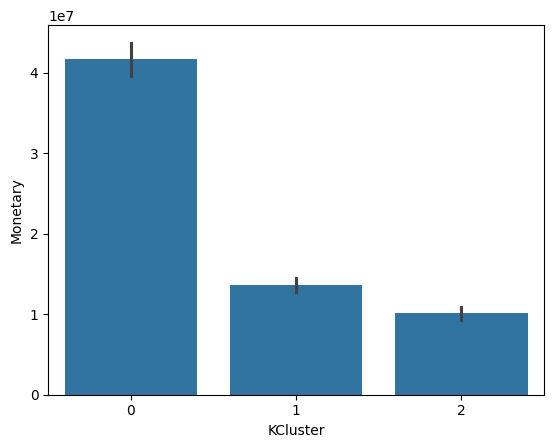

In [16]:
sns.barplot(data=RFM_Table, x='KCluster', y='Monetary')

<Axes: xlabel='KCluster', ylabel='Frequency'>

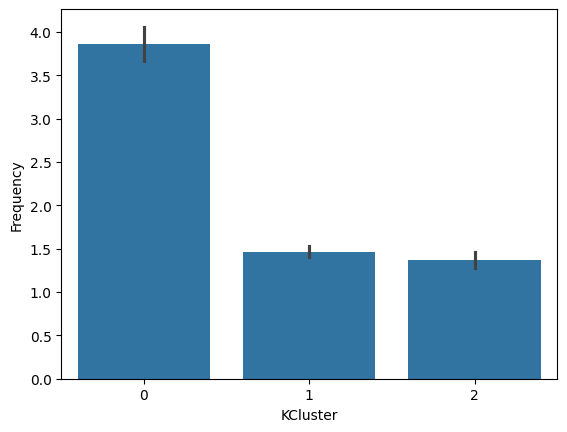

In [17]:
sns.barplot(data=RFM_Table, x='KCluster', y='Frequency')

# Find Best K with Inertia

In [18]:
wcss = {}
for k in range(1, 11):
    km = KMeans(n_clusters=k)
    km.fit(X)
    wcss[k] = km.inertia_

<Axes: >

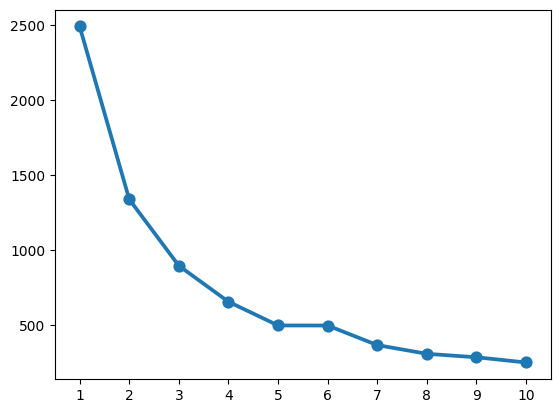

In [19]:
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))

# Evaluation Model

In [20]:
silhouette_score(X , kmean.labels_)

0.4263217660385994

# Simple DBscan model

In [21]:
DBS=DBSCAN(eps=0.7, min_samples=3)
DBS.fit(X)

np.unique(DBS.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int64)

# Evaluation Model

In [22]:
silhouette_score(X, DBS.labels_)

0.9933689575231861